In [2]:
from pyspark.sql import SparkSession
import shlex
import datetime
import dateutil
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.types import *
from pyspark.sql import Row 
from pyspark.sql.functions import col

In [3]:
import pandas as pd
from pyspark.sql import functions as F
from math import sqrt

In [49]:
from math import sqrt

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EQTaskWorker").getOrCreate()

In [9]:
df = spark.read.load('/works/congviec/EQ_works/ws-data-spark-master/data/DataSample.csv',
                     format="csv", sep=",", inferSchema="true", header="true")

In [10]:
df.first()

Row(_ID=4516516,  TimeSt=datetime.datetime(2017, 6, 21, 0, 0, 0, 143000), Country='CA', Province='ON', City='Waterloo', Latitude=43.49347, Longitude=-80.49123)

In [11]:
df.printSchema()

root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [9]:
df.count()

22025

In [12]:
#Correct the column " TimeSt"
df=df.select(col("_ID").alias("_ID"),col(" TimeSt").alias("TimeSt"),
             col("Country").alias("Country"),col("City").alias("City"),col("Latitude").alias("Latitude"),col("Longitude").alias("Longitude"))

In [13]:
df.printSchema()

root
 |-- _ID: integer (nullable = true)
 |-- TimeSt: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



# Cleaning duplicates

In [10]:
#Before dropping dup
df.count()

22025

In [14]:
#Drop rows if duplicate on TimeSt, Latitude and Longitude
clean_df=df.dropDuplicates(["TimeSt","Latitude","Longitude"])

In [15]:
clean_df.count()

19999

In [16]:
clean_df.select(['Latitude']).describe().show()
clean_df.select(['Longitude']).describe().show()

+-------+-----------------+
|summary|         Latitude|
+-------+-----------------+
|  count|            19999|
|   mean|47.98420511275566|
| stddev|4.154438211714902|
|    min|          6.92742|
|    max|          62.8273|
+-------+-----------------+

+-------+------------------+
|summary|         Longitude|
+-------+------------------+
|  count|             19999|
|   mean|-95.00772385069244|
| stddev| 19.03353047478451|
|    min|        -136.53957|
|    max|          125.7022|
+-------+------------------+



# Labelling

In [22]:
#POI data
poi_df = spark.read.load('data/POIList.csv',format="csv", sep=",", inferSchema="true", header="true")

In [18]:
print(poi_df.count())
poi_df.printSchema()

4
root
 |-- POIID: string (nullable = true)
 |--  Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [24]:
poi_df.head(4)

[Row(POIID='POI1',  Latitude=53.546167, Longitude=-113.485734),
 Row(POIID='POI3',  Latitude=45.521629, Longitude=-73.566024),
 Row(POIID='POI4',  Latitude=45.22483, Longitude=-63.232729)]

In [16]:
poi_df=poi_df.select(col('POIID').alias('POIID'),col(' Latitude').alias('Latitude'),col('Longitude').alias('Longitude'))
poi_df.printSchema()

root
 |-- POIID: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [23]:
# remove POI2 as its latitude and longitude are identical to POI1
poi_df=poi_df.filter(col('POIID')!='POI2')

In [26]:
poi_df_pandas=pd.DataFrame(poi_df.collect(),columns=['POIID','Latitude','Longitude'])

In [27]:
poi_df_pandas.head(4)

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI3,45.521629,-73.566024
2,POI4,45.224830,-63.232729


In [28]:
def get_closest_POI(lat,long):
    #Assume collect_poi_df is a broacast variable and locally available when running this on a cluster.
    tmp=pd.DataFrame()
    tmp['POIID']=poi_df_pandas['POIID']
    tmp['dis']=pow((poi_df_pandas['Latitude']-lat),2)+pow((poi_df_pandas['Longitude']-long),2)
    tmp=tmp.sort_values(by=['dis'])
    return tmp['POIID'].iloc[0]
get_closest_POI_udf=udf(get_closest_POI,StringType())

In [29]:
ret_schema = StructType([
    StructField("dis",DoubleType(), False),
    StructField("POIID",StringType(), False)
])

In [30]:
def v2_get_closest_POI(lat,long):
    #Assume collect_poi_df is a broacast variable and locally available when running this on a cluster.
    tmp=pd.DataFrame()
    tmp['POIID']=poi_df_pandas['POIID']
    tmp['dis']=(pow((poi_df_pandas['Latitude']-lat),2)+pow((poi_df_pandas['Longitude']-long),2))
    tmp=tmp.sort_values(by=['dis'])
    #return (tmp['dis'].iloc[0],tmp['POIID'].iloc[0])
    return Row('dis','POI')(float(tmp['dis'].iloc[0]),tmp['POIID'].iloc[0])
v2_get_closest_POI_udf=udf(v2_get_closest_POI,ret_schema)

In [31]:
def dis(lat,long,poi):
    tmp=poi_df_pandas[poi_df_pandas['POIID']==poi]
    x=sqrt(pow((tmp['Latitude']-lat),2) + pow((tmp['Longitude']-long),2))
    #print(type(x))
    return x
udf_dis=udf(dis,DoubleType())

In [35]:
clean_df=clean_df.withColumn('udf_v2',v2_get_closest_POI_udf(clean_df['Latitude'],clean_df['Longitude']))\
.select(col("_ID").alias("_ID"),col("TimeSt").alias("TimeSt"),
             col("Country").alias("Country"),col("City").alias("City"),col("Latitude").alias("Latitude"),\
        col("Longitude").alias("Longitude"),col("udf_v2.dis").alias("POI_distance"),col("udf_v2.POIID").alias('closest_POIID'))

In [50]:
def squared(x):
    return sqrt(x)
udf_squared=udf(squared,DoubleType())

In [51]:
clean_df=clean_df.withColumn('distance',udf_squared(clean_df['POI_distance']))

In [52]:
clean_df.head(10)

[Row(_ID=4673153, TimeSt=datetime.datetime(2017, 6, 21, 0, 9, 6, 990000), Country='CA', City='Mississauga', Latitude=43.6618, Longitude=-79.7034, POI_distance=41.126348074617034, closest_POIID='POI3', distance=6.412982775169214),
 Row(_ID=4734463, TimeSt=datetime.datetime(2017, 6, 21, 0, 14, 7, 310000), Country='CA', City='Laval', Latitude=45.6323, Longitude=-73.7579, POI_distance=0.04906446961700374, closest_POIID='POI3', distance=0.2215050103654627),
 Row(_ID=4788835, TimeSt=datetime.datetime(2017, 6, 21, 0, 17, 54, 407000), Country='CA', City='London', Latitude=43.0004, Longitude=-81.2343, POI_distance=65.15905248261708, closest_POIID='POI3', distance=8.072115737687183),
 Row(_ID=5583424, TimeSt=datetime.datetime(2017, 6, 21, 0, 20, 14, 900000), Country='CA', City='Gatineau', Latitude=45.3944, Longitude=-75.8363, POI_distance=5.17034033461698, closest_POIID='POI3', distance=2.27383823844551),
 Row(_ID=5085849, TimeSt=datetime.datetime(2017, 6, 21, 0, 39, 54, 60000), Country='CA', Ci

In [38]:
clean_df.groupBy('closest_POIID').count().show(3)

+-------------+-----+
|closest_POIID|count|
+-------------+-----+
|         POI4|  484|
|         POI1| 9698|
|         POI3| 9817|
+-------------+-----+



### 3.a Get stats for each POI

In [72]:
stats=clean_df.groupBy('closest_POIID').agg(F.avg(col('distance')).alias('dis_avg'),\
                                          F.stddev(col('distance')).alias('dis_std'),\
                                                   F.max(col('distance')).alias('radius'),\
                                            F.count(col('distance')).alias('no_request'))

In [73]:
stats.show(4)

+-------------+-----------------+------------------+------------------+----------+
|closest_POIID|          dis_avg|           dis_std|            radius|no_request|
+-------------+-----------------+------------------+------------------+----------+
|         POI4|8.810410862715697|28.675130269811007| 192.7049913074258|       484|
|         POI1|3.348183006325603|3.8584895715706775|24.851937229893878|      9698|
|         POI3|5.537950830488868|2.8586897295404903|20.155377791591437|      9817|
+-------------+-----------------+------------------+------------------+----------+



In [74]:
cstats=pd.DataFrame(stats.collect(),columns=['closest_POIID','dis_avg','is_std','radius','no_request'])

In [78]:
cstats['density']=cstats.apply(lambda x: x['no_request']/(3.14*x['radius']*x['radius']),axis=1)

In [79]:
cstats.head(3)

,closest_POIID,dis_avg,is_std,radius,no_request,density
0,POI4,8.810411,28.67513,192.704991,484,0.004151
1,POI1,3.348183,3.85849,24.851937,9698,5.000714
2,POI3,5.537951,2.85869,20.155378,9817,7.696039


In [57]:
cdat=clean_df.select(['_ID','Latitude','Longitude','distance','closest_POIID']).collect()

In [58]:
cdat_df=pd.DataFrame(cdat,columns=['_ID','Latitude','Longitude','distance','closest_POIID'])

In [59]:
cdat_df.head(10)

,_ID,Latitude,Longitude,distance,closest_POIID
0,4518918,42.93990,-81.27090,8.125912,POI3
1,4535779,45.50470,-73.55580,0.019777,POI3
2,4547425,43.57760,-80.22010,6.932242,POI3
3,4561012,48.37380,-89.27790,15.968655,POI3
4,4576329,42.28250,-83.03720,10.009752,POI3
5,4578136,53.40440,-113.52370,0.146763,POI1
6,4617922,45.57710,-73.68730,0.133360,POI3
7,4618117,53.55000,-113.13330,0.352455,POI1
8,4630340,51.04938,-113.94482,2.538642,POI1
9,4638863,43.64140,-79.41510,6.143855,POI3


In [81]:
lim=cdat_df[['Latitude','Longitude']].describe()

In [82]:
print(lim)

           Latitude     Longitude
count  19999.000000  19999.000000
mean      47.984205    -95.007724
std        4.154438     19.033530
min        6.927420   -136.539570
25%       43.747600   -113.817815
50%       48.151600    -83.018200
75%       51.127250    -79.399100
max       62.827300    125.702200


In [84]:
print(lim.loc['max']['Latitude'])

62.8273


In [162]:
import matplotlib
import matplotlib.pyplot as pplt
from IPython.display import display
%matplotlib inline 

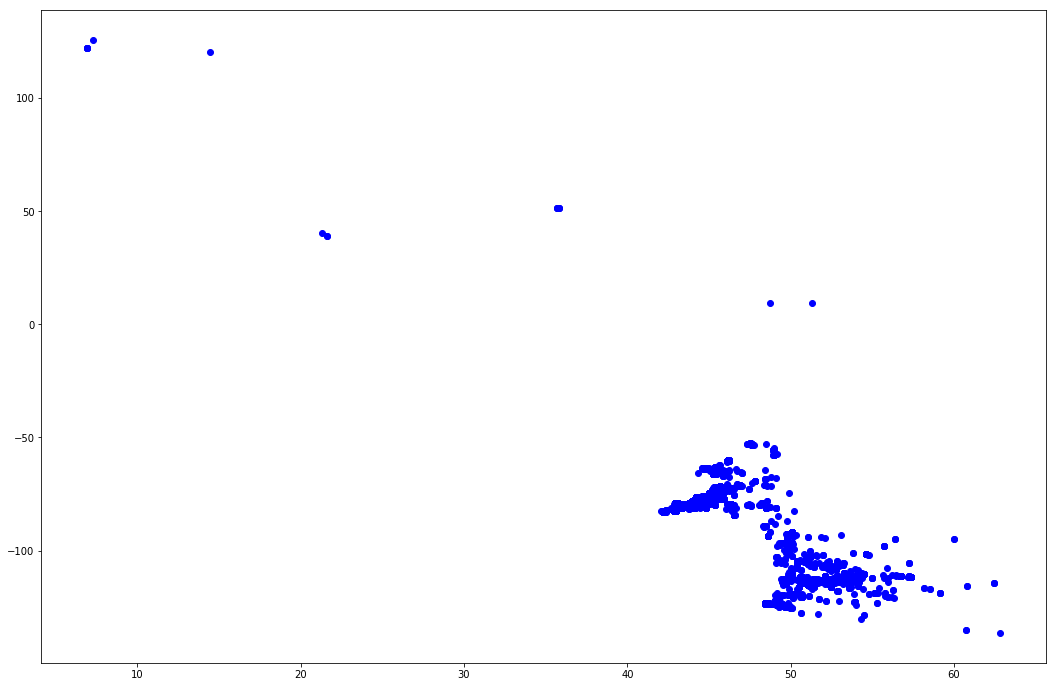

In [163]:
pplt.figure(figsize=(18,12))
pplt.plot(cdat_df['Latitude'],cdat_df['Longitude'],'bo')
pplt.show()

In [112]:
cstats.head(3)

,closest_POIID,dis_avg,is_std,radius,no_request,density
0,POI4,8.810411,28.67513,192.704991,484,0.004151
1,POI1,3.348183,3.85849,24.851937,9698,5.000714
2,POI3,5.537951,2.85869,20.155378,9817,7.696039


In [122]:
poi_df_pandas.head(4)

,POIID,Latitude,Longitude,color
0,POI1,53.546167,-113.485734,y
1,POI3,45.521629,-73.566024,c
2,POI4,45.224830,-63.232729,m


In [120]:
poi_df_pandas['color']=['y','c','m']

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

In [106]:
poi_df_pandas.loc[poi_df_pandas['POIID']=='POI1']['Latitude']

0    53.546167
Name: Latitude, dtype: float64

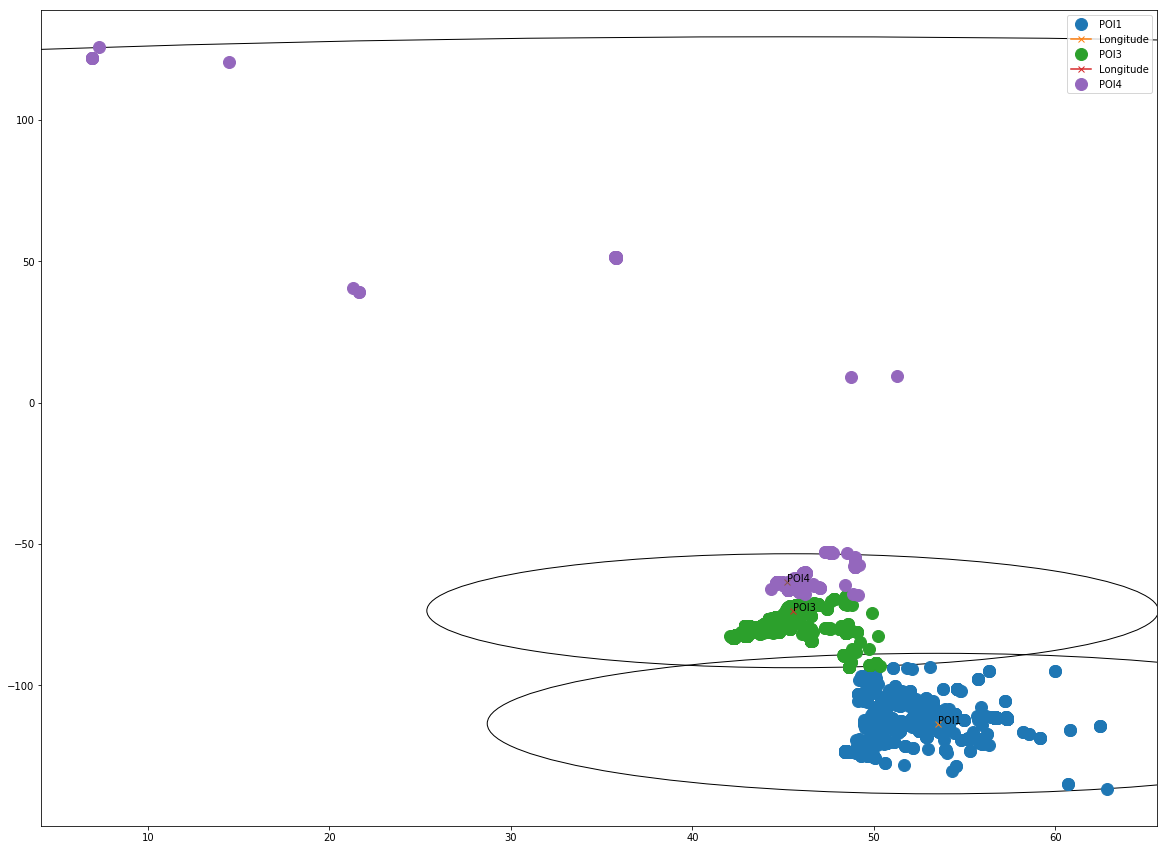

In [124]:
groups=cdat_df.groupby('closest_POIID')
fig, ax = plt.subplots()
ax.xlim=(lim.loc['min']['Latitude'],lim.loc['max']['Latitude'])
ax.xlim=(lim.loc['min']['Longitude'],lim.loc['max']['Longitude'])
#ax.margins(0.05)
for name, group in groups:
    #print(name)
    ax.plot(group.Latitude, group.Longitude,\
            #color=poi_df_pandas.loc[poi_df_pandas['POIID']==name]['color'],\
            marker='o', linestyle='', ms=12, label=name)
    ax.legend()
    ax.plot(poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Longitude'],marker='x')
    ax.annotate(name,(poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Longitude']))
    circle = plt.Circle((poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Latitude'],\
                         poi_df_pandas.loc[poi_df_pandas['POIID']==name]['Longitude']),\
                       cstats.loc[cstats['closest_POIID']==name]['radius'],fill=False,
                       # color=poi_df_pandas.loc[poi_df_pandas['POIID']==name]['color']
                       )
    ax.add_artist(circle)
    
plt.show()

# 4.a.1 Visualize

In [ ]:
# As we want to be sensitive around the average and maximize the differentiability, \
# we want to be able to focus on displaying data within a certain range of quantiles, and then use a linear mapping
# to map data within the chosen quantile range in to the desired range (-10,10), a linear mapping is a good choice
# as it preserves Euclidean distance between points, which is the original metric used to group points closest to a certain POIID.
# Suppose we pick (5%,95%) quantile range to map. Both X and Y need to use the same mapping to preserve distance relationship

In [147]:
quantiles = cdat_df[['closest_POIID','Latitude','Longitude']].groupby('closest_POIID').quantile([0.05,0.95])

In [148]:
quantiles.head(6)

Latitude   Longitude
closest_POIID                            
POI1          0.05  49.253668 -122.906000
              0.95  53.629900 -105.703553
POI3          0.05  43.034600  -81.323900
              0.95  46.511900  -73.556440
POI4          0.05  44.615250  -66.655800
              0.95  47.651715  -52.656600

In [177]:
quantiles = cdat_df[['distance','closest_POIID']].groupby('closest_POIID').quantile([0.95])

In [178]:
quantiles.head(6)

,,distance
closest_POIID,,
POI1,0.95,10.595565
POI3,0.95,8.172087
POI4,0.95,10.821120


In [141]:
cdat_df.head(4)

,_ID,Latitude,Longitude,distance,closest_POIID
0,4518918,42.9399,-81.2709,8.125912,POI3
1,4535779,45.5047,-73.5558,0.019777,POI3
2,4547425,43.5776,-80.2201,6.932242,POI3
3,4561012,48.3738,-89.2779,15.968655,POI3


In [174]:
p1_cdat_df=cdat_df.loc[cdat_df['closest_POIID']=='POI1']
p1_cdat_df=p1_cdat_df.loc[p1_cdat_df['distance'] < 10.595565]

# Visualize points within 95% quantile of distance from POI, ignoring those points outside of 95 pct quantile

In [155]:
p1_cdat_df.shape

(8081, 5)

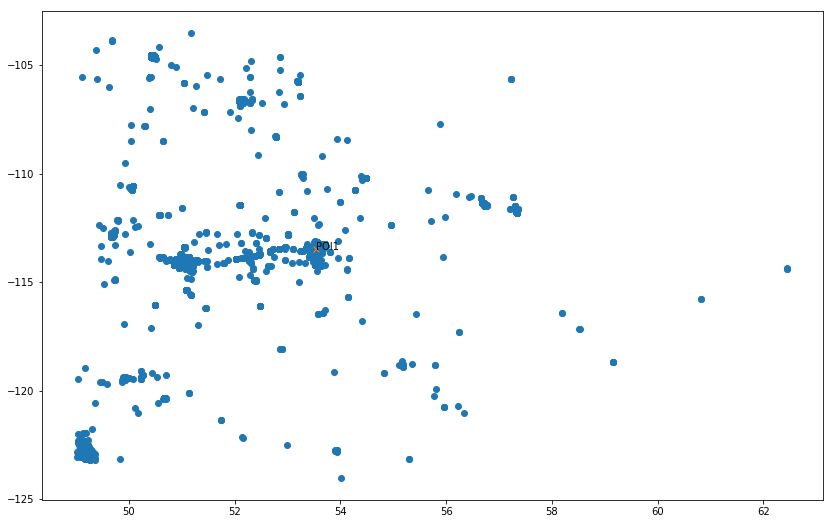

In [176]:
pplt.figure(figsize=(14,9))
pplt.plot(p1_cdat_df['Latitude'],p1_cdat_df['Longitude'],\
            marker='o', linestyle='', ms=6, label=name)
pplt.plot(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI1']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI1']['Longitude'],marker='x')
pplt.annotate('POI1',(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI1']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI1']['Longitude']))
pplt.show()

In [182]:
p3_cdat_df=cdat_df.loc[cdat_df['closest_POIID']=='POI3']
p3_cdat_df=p3_cdat_df.loc[p3_cdat_df['distance'] < 8.172087]

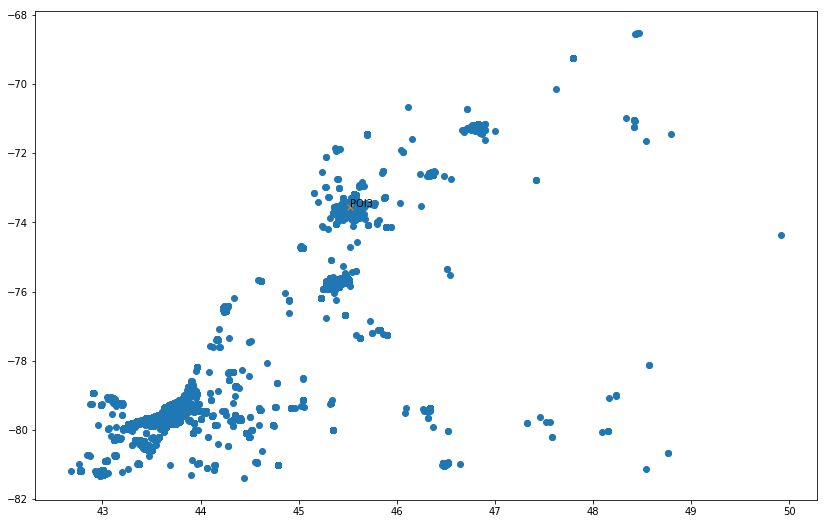

In [184]:
pplt.figure(figsize=(14,9))
pplt.plot(p3_cdat_df['Latitude'],p3_cdat_df['Longitude'],\
            marker='o', linestyle='', ms=6, label=name)
pplt.plot(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI3']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI3']['Longitude'],marker='x')
pplt.annotate('POI3',(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI3']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI3']['Longitude']))
pplt.show()

In [186]:
p4_cdat_df=cdat_df.loc[cdat_df['closest_POIID']=='POI4']
p4_cdat_df=p4_cdat_df.loc[p4_cdat_df['distance'] < 10.821120]

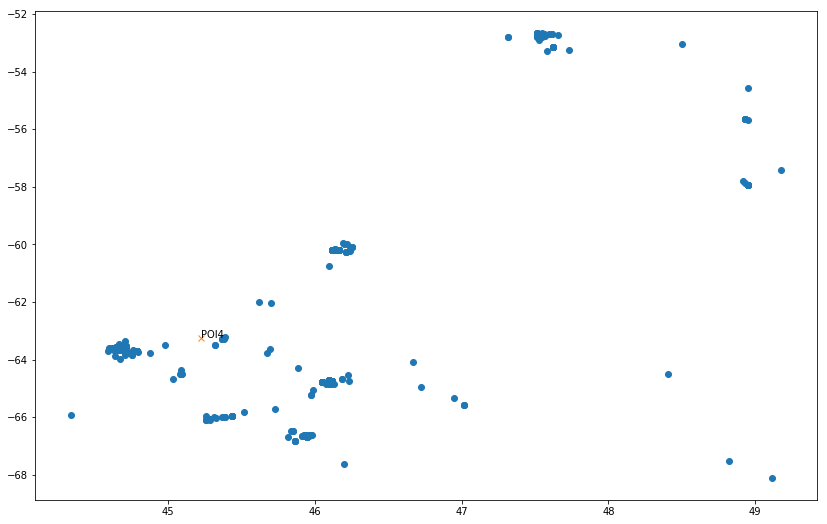

In [188]:
pplt.figure(figsize=(14,9))
pplt.plot(p4_cdat_df['Latitude'],p4_cdat_df['Longitude'],\
            marker='o', linestyle='', ms=6, label=name)
pplt.plot(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI4']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI4']['Longitude'],marker='x')
pplt.annotate('POI4',(poi_df_pandas.loc[poi_df_pandas['POIID']=='POI4']['Latitude'],\
                poi_df_pandas.loc[poi_df_pandas['POIID']=='POI4']['Longitude']))
pplt.show()

# 4a.2 Hypothesis about each POI-centered cloud of data

# 4b - Engineering

In [201]:
nodes=list()
with open('task_ids.txt','r') as f:
    line=f.readlines()
f.close()

In [202]:
print(line)

['97,75,100,102,16,39,41,62,112,20,21,73,56,55,36,37,94,31\n']


In [205]:
ids=line[0].strip().replace('\n','').split(',')
for i in ids:
    nodes.append(i)

In [206]:
print(nodes)

['97', '75', '100', '102', '16', '39', '41', '62', '112', '20', '21', '73', '56', '55', '36', '37', '94', '31']


In [308]:
forward_dict=dict()
backward_dict=dict()

In [309]:
with open('relations.txt','r') as f:
    lines=f.readlines()
f.close()
for l in lines:
    tmp=l.strip().replace('\n','').split('->')
    #print(tmp)
    if len(tmp)==2:
        if tmp[0] not in forward_dict.keys():
            forward_dict[tmp[0]]=[tmp[1]]
        else:
            ltmp=forward_dict[tmp[0]]
            ltmp.append(tmp[1])
            forward_dict[tmp[0]]=ltmp
        if tmp[1] not in backward_dict.keys():
            backward_dict[tmp[1]]=[tmp[0]]
        else:
            ltmp=backward_dict[tmp[1]]
            ltmp.append(tmp[0])
            backward_dict[tmp[1]]=ltmp
# add null forward and backward
for i in nodes:
    if i not in forward_dict.keys():
        forward_dict[i]=[]
    if i not in backward_dict.keys():
        backward_dict[i]=[]

In [310]:
print(forward_dict)

{'102': ['36', '37', '31'], '37': [], '62': ['55'], '73': ['20'], '41': ['73', '112'], '75': ['31', '37'], '31': [], '56': ['102', '75', '55'], '112': ['97'], '39': ['73', '100'], '55': ['31', '37'], '100': ['20'], '94': ['56', '102'], '16': ['37'], '20': ['94', '97'], '36': [], '97': ['102'], '21': ['20']}


In [311]:
print(backward_dict)

{'102': ['97', '56', '94'], '37': ['75', '102', '16', '55'], '55': ['62', '56'], '73': ['39', '41'], '41': [], '75': ['56'], '56': ['94'], '112': ['41'], '100': ['39'], '39': [], '62': [], '31': ['75', '102', '55'], '94': ['20'], '21': [], '20': ['100', '21', '73'], '36': ['102'], '97': ['112', '20'], '16': []}


In [312]:
print(len(backward_dict['55']))
print(len(backward_dict['16']))

2
0


In [325]:
#For a given task_id, get the set of required task to complete it
def get_dep(task_id):
    op = set([task_id])
    if len(backward_dict[task_id])==0:
        return set([task_id])
    else:
        dep=backward_dict[task_id]
        #print(dep)
        for i in dep:
                op.add(i)
                op = op | get_dep(i)
        return op           

In [326]:
test=get_dep('37')
print(test)

{'102', '37', '55', '73', '41', '100', '20', '16', '21', '62', '56', '112', '39', '94', '75', '97'}


In [327]:
print(get_dep('21'))

{'21'}


In [328]:
test2=get_dep('73')
print(test2)

{'39', '73', '41'}


In [329]:
### Get the set of tasks required for task '37', except those completed by task 73.
testdiff=test.difference(test2)
print(testdiff)

{'102', '37', '55', '100', '20', '16', '21', '62', '56', '112', '94', '75', '97'}


In [314]:
### Implement algo to ouput topological sorting
def DFS():
    topo_sort=[]
    color_dict=dict()
    def DFS_visit(i):
        color_dict[i]='G'
        for u in forward_dict[i]:
            if color_dict[u]=='W':
                DFS_visit(u)
        color_dict[i]='B'
        topo_sort.append(i)
        return
    for i in nodes:
        color_dict[i]='W'
    time=0
    for i in nodes:
        if color_dict[i]=='W':
            DFS_visit(i)           
    return topo_sort[::-1] 

In [315]:
tsort=DFS()

In [316]:
print(tsort)

['21', '62', '41', '112', '39', '73', '16', '100', '20', '94', '56', '55', '75', '97', '102', '31', '37', '36']


In [317]:
###Output the required task
def required_tasks(start,end):
    end_tasks = get_dep(end)
    start_tasks = get_dep(start)
    required_tasks = end_tasks.difference(start_tasks)
    #print(required_tasks)
    op = list()
    for i in tsort:
        if i in required_tasks:
            op.append(i)
    return op

In [330]:
print(required_tasks('73','37'))

['21', '62', '112', '16', '100', '20', '94', '56', '55', '75', '97', '102', '37']


In [331]:
print(required_tasks('21','37'))

['62', '41', '112', '39', '73', '16', '100', '20', '94', '56', '55', '75', '97', '102', '37']
